In [1]:
# !cp -r "/content/drive/MyDrive/my_data/Semi_ADDA/data/CALTECH_data.h5" ./CALTECH_data.h5
# !cp -r "/content/drive/MyDrive/my_data/Semi_ADDA/data/PASCAL_data.h5" ./PASCAL_data.h5
# !cp -r "/content/drive/MyDrive/my_data/Semi_ADDA/data/LABELME_data.h5" ./LABELME_data.h5
# !cp -r "/content/drive/MyDrive/my_data/Semi_ADDA/data/SUN_data.h5" ./SUN_data.h5

# Source code of SEMI-SUPERVISED ADVERSARIAL DISCRIMINATIVE DOMAIN ADAPTATION

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import classification_report

from imutils import build_montages
import h5py
from functools import reduce
import os
import scipy.io as sio
import urllib.request
import shutil

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, \
    Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, LeakyReLU, GlobalAveragePooling2D, Conv2DTranspose, \
    Reshape, Lambda, ReLU
from tensorflow.keras.models import  Model, load_model, Sequential, clone_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.python.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend

# Hyperparameter

In [3]:
TRAIN_SOURCE_EPOCHS = 30
ADVERSARIAL_EPOCHS = 20
BATCH_SIZE = 64
NUM_CLASSES = 5

IMAGE_SIZE = 64
IMAGE_CHANNEL = 3
LABEL_NAMES = ['bird', 'car', 'chair', 'dog', 'person']

# params for source dataset and target dataset
src_dataset = "labelme"
src_model_trained = True
tgt_dataset = "caltech"
tgt_model_trained = True

# params for optimizing models
d_learning_rate = 1e-4
c_learning_rate = 1e-4
BETA1 = 0.5
BETA2 = 0.9

# Get dataset 

In [4]:
def read_file_data(file_name='/content/CALTECH_data.h5'):

    hf = h5py.File(file_name, 'r')
    
    X_train = hf.get('X_train')
    y_train = hf.get('y_train')
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_validation = hf.get('X_validation')
    y_validation = hf.get('y_validation')
    X_validation = np.array(X_validation)
    y_validation = np.array(y_validation)

    X_test = hf.get('X_test')
    y_test = hf.get('y_test')
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    hf.close()
    return ((X_train, y_train), (X_validation, y_validation), (X_test, y_test))

In [5]:
def get_dataset(dataset='caltech'):
    
    if dataset=='caltech':
        ((X_train, y_train), (X_validation, y_validation), (X_test, y_test)) = read_file_data(file_name='/content/CALTECH_data.h5')
    elif dataset=='labelme':
        ((X_train, y_train), (X_validation, y_validation), (X_test, y_test)) = read_file_data(file_name='/content/LABELME_data.h5')
    elif dataset=='pascal':
        ((X_train, y_train), (X_validation, y_validation), (X_test, y_test)) = read_file_data(file_name='/content/PASCAL_data.h5')
    elif dataset=='sun':
        ((X_train, y_train), (X_validation, y_validation), (X_test, y_test)) = read_file_data(file_name='/content/SUN_data.h5')
    
    y_train = to_categorical(y_train, NUM_CLASSES)
    y_validation = to_categorical(y_validation, NUM_CLASSES)
    y_test = to_categorical(y_test, NUM_CLASSES)

    print("---------- INFOR OF DATASET ----------")
    print("Name: {}".format(dataset))
    print("---- X train shape: {}".format(X_train.shape))
    print("---- y train shape: {}".format(y_train.shape))
    print("---- X validation shape: {}".format(X_validation.shape))
    print("---- y validation shape: {}".format(y_validation.shape))
    print("---- X test shape: {}".format(X_test.shape))
    print("---- y test shape: {}".format(y_test.shape))
    
    return ((X_train, y_train), (X_validation, y_validation), (X_test, y_test))

In [6]:
((X_train, y_train), (X_validation, y_validation), (X_test, y_test)) = get_dataset(src_dataset)

---------- INFOR OF DATASET ----------
Name: labelme
---- X train shape: (20000, 64, 64, 3)
---- y train shape: (20000, 5)
---- X validation shape: (2500, 64, 64, 3)
---- y validation shape: (2500, 5)
---- X test shape: (2500, 64, 64, 3)
---- y test shape: (2500, 5)


Label: car
Image shape: (64, 64, 3)


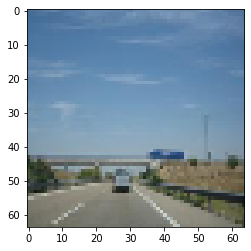

In [7]:
# Random plot image
idx = np.random.randint(0, X_train.shape[0])
test_image = X_train[idx]
print("Label: {}".format(LABEL_NAMES[y_train[idx].argmax()]))
print("Image shape: {}".format(test_image.shape))

plt.imshow(test_image)

# Define utils function

In [8]:
# Nomalize preprocessor 
class NomalizePreprocessor:
    def __init__(self):
        pass

    def preprocess(self, image):

        # Normalize image in range [0, 1]
        image = image.astype(np.float32)
        image = (image - 127.5) / 127.5 

        # Normalize image in range [0, 1]
        # image = image.astype(np.float32) / 255.0

        return image

In [9]:
def PredictGenerator(X, batchSize, preprocessors = None):

    N = X.shape[0]

    for i in np.arange(0, N, batchSize):

        images = X[i: i+batchSize]

        if preprocessors is not None:
            procImages = []

            for image in images:
                for p in preprocessors:
                    image = p.preprocess(image)

                procImages.append(image)
            
            images = np.array(procImages)

        yield images

In [10]:
def DatasetGenerator(X, y, batchSize, preprocessors = None, aug = None):

    N = X.shape[0]

    while True:

        # loop over dataset
        for i in np.arange(0, N, batchSize):

            images = X[i: i+batchSize]
            labels = y[i: i+batchSize]

            # check to see if our preprocessors are not None
            if preprocessors is not None:

                # initialize the list of processed images
                procImages = []

                # loop over the images
                for image in images:
                    # loop over the preprocessors and apply each to the image
                    for p in preprocessors:
                        image = p.preprocess(image)

                    # update the list of processed images
                    procImages.append(image)
                
                # update the images array to be the processed images
                images = np.array(procImages)

            if aug is not None: 
                (images, labels) = next(aug.flow(images, labels, batch_size=batchSize))

            # yield a tuple of images and labels
            yield (images, labels)

In [11]:
def Predict_Encoder_Classifier(encoder_model, classifier_model, X, batchSize, preprocessors = None):

    predict_labels = np.zeros(shape=(1, NUM_CLASSES))

    N = X.shape[0]

    for i in np.arange(0, N, batchSize):

        images = X[i: i+batchSize]

        if preprocessors is not None:
            procImages = []

            for image in images:
                for p in preprocessors:
                    image = p.preprocess(image)

                procImages.append(image)
            
            images = np.array(procImages)

        predicts = classifier_model(encoder_model(images))

        predict_labels = np.concatenate((predict_labels, predicts))
    
    return predict_labels[1:] 

# Adversarial discriminator domain adaptation

In [12]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

In [13]:
class ADDA():
    def __init__(self, source_lr=0.001, disc_lr=0.0002):
        
        # Input shape 
        self.img_rows = IMAGE_SIZE
        self.img_cols = IMAGE_SIZE
        self.channels = IMAGE_CHANNEL
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.src_flag = False
        self.tgt_flag = False
        self.disc_flag = False
        self.classifier_flag = False

        self.src_optimizer = Adam(source_lr)
        self.disc_optimizer = Adam(disc_lr, beta_1=0.5, beta_2=0.9)

        self.num_outputs = NUM_CLASSES

        self.feature_map = 32

    def define_source_encoder(self, weights=None):
        
        self.source_encoder = Sequential()
        self.source_encoder.add(Input(shape=self.img_shape))

        self.source_encoder.add(Conv2D(self.feature_map, (4,4), strides=(2,2), padding="same"))
        # self.source_encoder.add(BatchNormalization())
        self.source_encoder.add(ReLU())

        self.source_encoder.add(Conv2D(self.feature_map * 2, (4,4), strides=(2,2), padding="same"))
        # self.source_encoder.add(BatchNormalization())
        self.source_encoder.add(ReLU())
        
        self.source_encoder.add(Conv2D(self.feature_map * 4, (4,4), strides=(2,2), padding="same"))
        # self.source_encoder.add(BatchNormalization())
        self.source_encoder.add(ReLU())

        self.source_encoder.add(Conv2D(self.feature_map * 8, (4,4), strides=(2,2), padding="same"))
        # self.source_encoder.add(BatchNormalization())
        self.source_encoder.add(ReLU())
        
        self.src_flag = True

        if weights is not None:
            self.source_encoder.load_weights(weights, by_name=True)
    
    def define_target_encoder(self, weights=None):
        
        if not self.src_flag:
            self.define_source_encoder()
        
        with tf.device('/cpu:0'):
            self.target_encoder = clone_model(self.source_encoder)
            self.tgt_flag = True
        
        if weights is not None:
            self.target_encoder.load_weights(weights, by_name=True)

    def define_classifier(self, weights=None):

        inputShape = self.source_encoder.output.shape[1:]

        self.classifier = Sequential(name="Classifier")
        self.classifier.add(Input(shape=inputShape))

        self.classifier.add(GlobalAveragePooling2D())
        self.classifier.add(Dense(100, activation="relu"))
        self.classifier.add(Dropout(0.5))
        self.classifier.add(Dense(self.num_outputs, activation="softmax"))

        self.classifier_flag = True
        self.classifier.summary()

        if weights is not None:
            self.classifier.load_weights(weights, by_name=True)


    def get_encoder_and_classifier(self, weights_classifier=None):
        
        if not self.classifier_flag:
            self.define_classifier(weights_classifier)

        input = self.source_encoder.inputs
        output = self.classifier(self.source_encoder.outputs)

        encoder_classifier_model = Model(inputs=input, outputs=output, name="encoder_classifier")
        
        return encoder_classifier_model

    def define_discriminator(self, encoder_output_shape, hiddens_3 = NUM_CLASSES):

        inp = Input(shape=encoder_output_shape)

        x = Conv2DTranspose(self.feature_map * 4, (4, 4), strides=(2,2), padding="same")(inp)
        # x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2DTranspose(self.feature_map * 2, (4, 4), strides=(2,2), padding="same")(x)
        # x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        
        x = Conv2DTranspose(self.feature_map, (4, 4), strides=(2,2), padding="same")(x)
        # x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2DTranspose(IMAGE_CHANNEL, (4, 4), strides=(2,2), padding="same")(x)
        # x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Flatten()(x)

        x = Dense(hiddens_3, name='discriminator3')(x)

        # Define unsupervised discriminator model
        d_out_layer = Lambda(custom_activation)(x)
        self.discriminator_model = Model(inputs=(inp), outputs=(d_out_layer), name='unsupervised_discriminator')

        # Define supervised discriminator
        c_out_layer = Activation("softmax")(x)
        self.supervised_discriminator_model = Model(inputs=(inp), outputs=(c_out_layer), name="supervised_discriminator")

        self.disc_flag = True


    def get_whole_encoder_and_discriminator(self, encoder, weights=None):
        
        if not self.disc_flag:
            self.define_discriminator(encoder.output_shape[1:])
        
        disc = Model(inputs=(encoder.input), outputs=(self.discriminator_model(encoder.output)))
        
        if weights is not None:
            disc.load_weights(weights, by_name=True)
        
        return disc

    def train_source_model(self, model, epochs=TRAIN_SOURCE_EPOCHS, batch_size=BATCH_SIZE, save_interval=1):

        if not os.path.isdir('model'):
            os.mkdir('model')

        ((X_train, y_train), (X_validation, y_validation), (X_test, y_test)) = get_dataset(src_dataset)

        # Preprocess
        normPro = NomalizePreprocessor()

        # Dataset generator
        trainGen = DatasetGenerator(X_train, y_train, batchSize=batch_size, preprocessors = [normPro])
        valGen = DatasetGenerator(X_validation, y_validation, batchSize=batch_size, preprocessors = [normPro])

        # Early stopping
        earlyStoppingCallback = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta=0, patience=5, restore_best_weights=True)

        model.compile(loss='categorical_crossentropy', optimizer=self.src_optimizer, metrics=['accuracy'])
        model.summary()

        N_train = X_train.shape[0]
        N_val = X_validation.shape[0]

        STEPS_PER_EPOCH = N_train//batch_size
        VAL_STEPS = N_val//batch_size

        model.fit(trainGen, \
                steps_per_epoch = STEPS_PER_EPOCH, \
                validation_data = valGen, \
                validation_steps = VAL_STEPS, \
                epochs = epochs, \
                callbacks=[earlyStoppingCallback], verbose=1)
        
        # Evaluate on testing dataset
        testGen = PredictGenerator(X_test, batchSize=BATCH_SIZE, preprocessors = [normPro])
        y_test_predict = model.predict(testGen)

        print('---CLASSIFICATION REPORT ---')
        print(classification_report(y_true=y_test.argmax(axis=1), y_pred=y_test_predict.argmax(axis=1)))
    
        # Save classification model
        model.save(os.path.join("model", "source_classification.h5"))
        
        # Save source encoder model 
        source_encoder = Sequential()
        source_encoder.build(self.img_shape)

        for layer in model.layers[:-1]:
            source_encoder.add(layer)

        source_encoder.save(os.path.join("model", "source_encoder.h5"))

        # Save classifier model
        classifier_model = Sequential()
        classifier_model.add(Input(source_encoder.output_shape[1:]))

        for layer in model.layers[-1:]:
            classifier_model.add(layer)

        classifier_model.save(os.path.join("model", "classifier.h5"))

    # ====================================================================================

    def train_target(self, epochs=ADVERSARIAL_EPOCHS, batch_size=BATCH_SIZE, save_interval=1,
                    test_images=None, test_labels=None):

        # 1. Load dataset and define preprocessing method
        ((X_train_source, y_train_source), (X_validation_source, y_validation_source), (_, _)) = get_dataset(src_dataset)
        source_image = np.concatenate([X_train_source, X_validation_source])
        source_label = np.concatenate([y_train_source, y_validation_source])

        ((X_train_target, y_train_target), (X_validation_target, y_validation_target), (_, _)) = get_dataset(tgt_dataset)
        target_image = np.concatenate([X_train_target, X_validation_target])

        normPro = NomalizePreprocessor()

        # 2. Define target encoder (if it doesn't exits)
        if not self.tgt_flag:
            weights = os.path.join("model", "source_encoder.h5")
            if os.path.isfile(weights):
                print("[INFO]: target_encoder is copy from {}".format(weights))
                self.define_target_encoder(weights)
            else:
                self.define_target_encoder()
        
        # 3. Compile supervised discriminator model and unsupervised discriminator model
        self.supervised_discriminator_model.compile(loss='categorical_crossentropy', optimizer=self.disc_optimizer, metrics=['accuracy'])
        self.supervised_discriminator_model.summary()

        self.discriminator_model.compile(loss="binary_crossentropy", optimizer=self.disc_optimizer)
        self.discriminator_model.summary()

        # Build adversarial model by setting the discriminator to *not* be trainable
        self.discriminator_model.trainable = False

        whole_target_disc_model = self.get_whole_encoder_and_discriminator(self.target_encoder)
        whole_target_disc_model.compile(loss="binary_crossentropy", optimizer=self.disc_optimizer)
        whole_target_disc_model.summary()

        # 4. Loop through epoch
        for epoch in range(0, epochs):
            
            print("-----[INFO] starting epoch {} of {}...".format(epoch, epochs))     

            # Calculate accuracy (for testing purpose)
            if epoch % 2 == 0:

                # Checkpoint target_encoder
                file_name = "target_encode_{}.h5".format(epoch)
                self.target_encoder.save(os.path.join("model", file_name))

                # Load classifier model
                classifier_model = load_model("/content/model/classifier.h5")
                
                # Predict
                normPro = NomalizePreprocessor()
                predict_labels = Predict_Encoder_Classifier(self.target_encoder, classifier_model, test_images, batchSize=batch_size, preprocessors=[normPro])

                # Calculate accuracy
                accuracy = np.sum(predict_labels.argmax(-1) == test_labels.argmax(-1)) / len(test_labels)
                print(" * Accuracy at epoch {}: is {}".format(epoch, accuracy))       
            
            # Update learning rate of discriminator 
            if (epoch > 0) and (epoch % 10 == 0):
                new_learning_rate = self.disc_optimizer.learning_rate / 10.0
                print(" * Update learning rate of discriminator model to: ", new_learning_rate)
                print(" * Update learning rate of the whole model to: ", new_learning_rate)
                backend.set_value(self.discriminator_model.optimizer.learning_rate, new_learning_rate)
                backend.set_value(self.supervised_discriminator_model.optimizer.learning_rate, new_learning_rate)
            
            N = max([source_image.shape[0], target_image.shape[0]])
            n_steps = N // batch_size
            for i in np.arange(n_steps):

                idx_source = np.random.randint(0, source_image.shape[0], batch_size)
                batch_source_image = source_image[idx_source]
                batch_source_label = source_label[idx_source]

                idx_target = np.random.randint(0, target_image.shape[0], batch_size)
                batch_target_image = target_image[idx_target]

                # ----- Preprocess image -----
                processed_batch_source_image = []
                for image in batch_source_image:
                    image = normPro.preprocess(image)
                    processed_batch_source_image.append(image)
                batch_source_image = np.array(processed_batch_source_image)

                processed_batch_target_image = []
                for image in batch_target_image:
                    image = normPro.preprocess(image)
                    processed_batch_target_image.append(image)
                    
                batch_target_image = np.array(processed_batch_target_image)

                # ----- Prepare data -----
                source_encode = self.source_encoder.predict(batch_source_image)
                target_encode = self.target_encoder.predict(batch_target_image)
                encode = np.concatenate((source_encode, target_encode))
                
                encode_label = ([0.9] * batch_source_image.shape[0]) + ([0.1] * batch_target_image.shape[0])  # soft label: source: 0.9, target: 0.1
                encode_label = np.reshape(encode_label, (-1,))
                (encode, encode_label) = shuffle(encode, encode_label)

                # ----- Train supervised discriminator -----
                classificationLloss = self.supervised_discriminator_model.train_on_batch(source_encode, batch_source_label)

                # ----- Train unsupervised discriminator -----
                discLoss = self.discriminator_model.train_on_batch(encode, encode_label)

                # ----- Train target encoder -----
                fakeLabels = [1.0] * batch_target_image.shape[0]
                fakeLabels = np.reshape(fakeLabels, (-1,))
                (batch_target_image, fakeLabels) = shuffle(batch_target_image, fakeLabels)

                # ----- Adversarial training with interted label -----
                adversarialLoss = whole_target_disc_model.train_on_batch(batch_target_image, fakeLabels)

            print("Classification loss: {}, discriminator loss: {}, adversarial loss: {}".format(classificationLloss, discLoss, adversarialLoss))

        self.target_encoder.save(os.path.join("model", "target_encoder.h5"))

# Training

In [14]:
# Training base model

adda = ADDA()

adda.define_source_encoder()

adda.define_classifier()

model = adda.get_encoder_and_classifier()

adda.train_source_model(model, epochs=TRAIN_SOURCE_EPOCHS)

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
---------- INFOR OF DATASET ----------
Name: labelme
---- X train shape: (20000, 64, 64, 3)
---- y train shape: (20000

---CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       497
           1       0.79      0.78      0.78       525
           2       0.93      0.94      0.93       481
           3       0.96      0.95      0.96       507
           4       0.71      0.74      0.73       490

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



In [15]:
# Load target dataset

((X_train_target, y_train_target), (X_validation_target, y_validation_target), (_, _)) = get_dataset(tgt_dataset)

target_x = np.concatenate((X_train_target, X_validation_target), axis=0)
target_y = np.concatenate((y_train_target, y_validation_target), axis=0)

---------- INFOR OF DATASET ----------
Name: caltech
---- X train shape: (20000, 64, 64, 3)
---- y train shape: (20000, 5)
---- X validation shape: (2500, 64, 64, 3)
---- y validation shape: (2500, 5)
---- X test shape: (2500, 64, 64, 3)
---- y test shape: (2500, 5)


In [16]:
model = load_model("/content/model/source_classification.h5")

# Preprocess
normPro = NomalizePreprocessor()

# Predict
testGen = PredictGenerator(target_x, batchSize=BATCH_SIZE, preprocessors = [normPro])

predict_labels = model.predict(testGen)

# Calculate accuracy
accuracy = np.sum(predict_labels.argmax(-1) == target_y.argmax(-1)) / len(target_y)

print("Accuracy is {}".format(accuracy))

Accuracy is 0.31751111111111113


In [17]:
# Training adversarial network

adda.define_discriminator(adda.source_encoder.output_shape[1:])
adda.train_target(epochs=ADVERSARIAL_EPOCHS, test_images=target_x, test_labels=target_y)

---------- INFOR OF DATASET ----------
Name: labelme
---- X train shape: (20000, 64, 64, 3)
---- y train shape: (20000, 5)
---- X validation shape: (2500, 64, 64, 3)
---- y validation shape: (2500, 5)
---- X test shape: (2500, 64, 64, 3)
---- y test shape: (2500, 5)
---------- INFOR OF DATASET ----------
Name: caltech
---- X train shape: (20000, 64, 64, 3)
---- y train shape: (20000, 5)
---- X validation shape: (2500, 64, 64, 3)
---- y validation shape: (2500, 5)
---- X test shape: (2500, 64, 64, 3)
---- y test shape: (2500, 5)
[INFO]: target_encoder is copy from model/source_encoder.h5
Model: "supervised_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 4, 256)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                  

-----[INFO] starting epoch 0 of 20...


 * Accuracy at epoch 0: is 0.31751111111111113
Classification loss: [0.05339164286851883, 1.0], discriminator loss: 0.5326501131057739, adversarial loss: 1.1928521394729614
-----[INFO] starting epoch 1 of 20...


Classification loss: [0.016814637929201126, 1.0], discriminator loss: 0.4815428555011749, adversarial loss: 1.4615404605865479
-----[INFO] starting epoch 2 of 20...
 * Accuracy at epoch 2: is 0.4212888888888889
Classification loss: [0.03607308864593506, 0.984375], discriminator loss: 0.4545063078403473, adversarial loss: 1.875016689300537
-----[INFO] starting epoch 3 of 20...


Classification loss: [0.026041947305202484, 1.0], discriminator loss: 0.45777490735054016, adversarial loss: 1.5607380867004395
-----[INFO] starting epoch 4 of 20...
 * Accuracy at epoch 4: is 0.4126666666666667
Classification loss: [0.0627671480178833, 0.984375], discriminator loss: 0.43504977226257324, adversarial loss: 2.14914870262146
-----[INFO] starting epoch 5 of 20...


Classification loss: [0.015612173825502396, 1.0], discriminator loss: 0.3942447900772095, adversarial loss: 2.0636379718780518
-----[INFO] starting epoch 6 of 20...
 * Accuracy at epoch 6: is 0.41346666666666665
Classification loss: [0.00872910674661398, 1.0], discriminator loss: 0.37695181369781494, adversarial loss: 2.3064842224121094
-----[INFO] starting epoch 7 of 20...


Classification loss: [0.005006415769457817, 1.0], discriminator loss: 0.39206674695014954, adversarial loss: 2.0003461837768555
-----[INFO] starting epoch 8 of 20...
 * Accuracy at epoch 8: is 0.4265333333333333
Classification loss: [0.003885036800056696, 1.0], discriminator loss: 0.36920255422592163, adversarial loss: 2.370940685272217
-----[INFO] starting epoch 9 of 20...


Classification loss: [0.002482770709320903, 1.0], discriminator loss: 0.36744141578674316, adversarial loss: 2.615706443786621
-----[INFO] starting epoch 10 of 20...
 * Accuracy at epoch 10: is 0.4002222222222222
 * Update learning rate of discriminator model to:  tf.Tensor(2e-05, shape=(), dtype=float32)
 * Update learning rate of the whole model to:  tf.Tensor(2e-05, shape=(), dtype=float32)
Classification loss: [0.0026985076256096363, 1.0], discriminator loss: 0.35662364959716797, adversarial loss: 2.2550392150878906
-----[INFO] starting epoch 11 of 20...


Classification loss: [0.0021507302299141884, 1.0], discriminator loss: 0.3458896577358246, adversarial loss: 2.2862608432769775
-----[INFO] starting epoch 12 of 20...
 * Accuracy at epoch 12: is 0.41075555555555554
Classification loss: [0.0017684760969132185, 1.0], discriminator loss: 0.3416332006454468, adversarial loss: 2.3390700817108154
-----[INFO] starting epoch 13 of 20...


Classification loss: [0.00077054463326931, 1.0], discriminator loss: 0.3414863348007202, adversarial loss: 2.403653621673584
-----[INFO] starting epoch 14 of 20...
 * Accuracy at epoch 14: is 0.4166666666666667
Classification loss: [0.0007943145465105772, 1.0], discriminator loss: 0.33924585580825806, adversarial loss: 2.4550833702087402
-----[INFO] starting epoch 15 of 20...


Classification loss: [0.0009978319285437465, 1.0], discriminator loss: 0.33601075410842896, adversarial loss: 2.283836841583252
-----[INFO] starting epoch 16 of 20...
 * Accuracy at epoch 16: is 0.4202666666666667
Classification loss: [0.0007056323811411858, 1.0], discriminator loss: 0.33496326208114624, adversarial loss: 2.2531862258911133
-----[INFO] starting epoch 17 of 20...


Classification loss: [0.000953222974203527, 1.0], discriminator loss: 0.3360322117805481, adversarial loss: 2.298093557357788
-----[INFO] starting epoch 18 of 20...
 * Accuracy at epoch 18: is 0.42004444444444444
Classification loss: [0.0005283233476802707, 1.0], discriminator loss: 0.3338906168937683, adversarial loss: 2.3598904609680176
-----[INFO] starting epoch 19 of 20...


Classification loss: [0.0007404007483273745, 1.0], discriminator loss: 0.3356924057006836, adversarial loss: 2.281806707382202


# Predict

## Predict on the train and validation dataset

In [18]:
# Predict on the train and validation dataset

encoder_model = load_model("/content/model/target_encoder.h5")

classifier_model = load_model("/content/model/classifier.h5")

predict_labels = Predict_Encoder_Classifier(encoder_model, classifier_model, target_x, batchSize=BATCH_SIZE, preprocessors = [normPro])

# Calculate accuracy
accuracy = np.sum(predict_labels.argmax(-1) == target_y.argmax(-1)) / len(target_y)

print("Accuracy is {}".format(accuracy))

Accuracy is 0.4198222222222222


## Predit on the testing dataset

In [19]:
# Load target dataset
((_, _), (_, _), (X_testing_target, y_testing_target)) = get_dataset(tgt_dataset)

# Predict
encoder_model = load_model("/content/model/target_encoder.h5")
classifier_model = load_model("/content/model/classifier.h5")

predict_labels = Predict_Encoder_Classifier(encoder_model, classifier_model, X_testing_target, batchSize=BATCH_SIZE, preprocessors = [normPro])

# Calculate accuracy
accuracy = np.sum(predict_labels.argmax(-1) == y_testing_target.argmax(-1)) / len(y_testing_target)
print("Accuracy is {}".format(accuracy))

---------- INFOR OF DATASET ----------
Name: caltech
---- X train shape: (20000, 64, 64, 3)
---- y train shape: (20000, 5)
---- X validation shape: (2500, 64, 64, 3)
---- y validation shape: (2500, 5)
---- X test shape: (2500, 64, 64, 3)
---- y test shape: (2500, 5)


Accuracy is 0.41
